# EEG Decoding Tutorial - Session 1
The goal of this notebook is to go through basic steps involved in getting from raw to evoked data.
It is largely based on this workshop: https://github.com/jona-sassenhagen/mne_workshop_amsterdam

* read in raw data, plot raw data
* Epochs
* Evokeds

**To-Do**
* add more comments
* include ICA? or not? If so where?
* more plots?

## Reading in raw data, working with raw objects

In [1]:
%matplotlib notebook
import mne
import matplotlib.pyplot as plt

fname = "oddball_example_small-fif.gz"

In [2]:
raw = mne.io.read_raw_fif(fname)

Opening raw data file oddball_example_small-fif.gz...


<ipython-input-2-78767f98f250>:1: RuntimeWarning: This filename (oddball_example_small-fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw = mne.io.read_raw_fif(fname)


Isotrak not found
    Range : 2903 ... 112000 =     29.030 ...  1120.000 secs
Ready.


MNE is *object oriented*. Objects have corresponding methods. Check which by typing `raw.` and pressing TAB:

In [3]:
raw.

SyntaxError: invalid syntax (<ipython-input-3-781418d1e4c2>, line 1)

We can also inspect our raw data

<IPython.core.display.Javascript object>


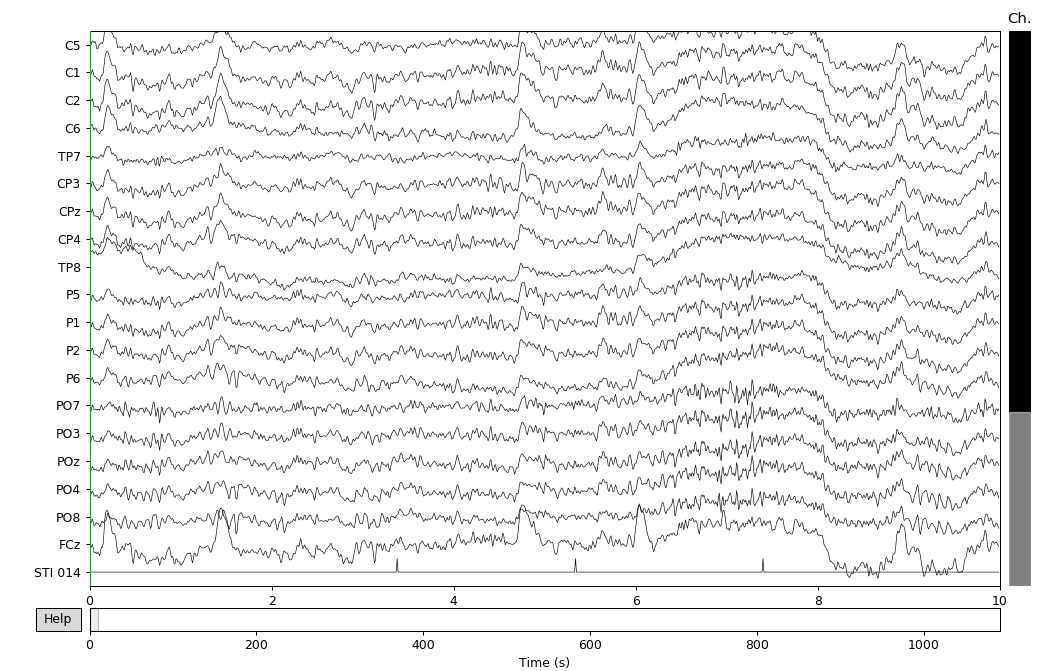

In [4]:
raw.plot();

try applying a filter to our `raw` object

In [5]:
raw.filter(1, 20)

RuntimeError: By default, MNE does not load data into main memory to conserve resources. raw.filter requires raw data to be loaded. Use preload=True (or string) in the constructor or raw.load_data().

mne tells us, that it doesn't store raw objects in memory. But it gives us the option to define `preload=True` when reading in raw files 

In [6]:
raw = mne.io.read_raw_fif(fname, preload=True)

Opening raw data file oddball_example_small-fif.gz...


<ipython-input-6-7341ee706cdd>:1: RuntimeWarning: This filename (oddball_example_small-fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw = mne.io.read_raw_fif(fname, preload=True)


Isotrak not found
    Range : 2903 ... 112000 =     29.030 ...  1120.000 secs
Ready.
Reading 0 ... 109097  =      0.000 ...  1090.970 secs...


now try filtering again...

In [7]:
raw.filter(1, 20)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 331 samples (3.310 sec)



<Raw  |  oddball_example_small-fif.gz, n_channels x n_times : 64 x 109098 (1091.0 sec), ~53.4 MB, data loaded>

Now we can inspect our raw data again. Do we notice anything?

<IPython.core.display.Javascript object>


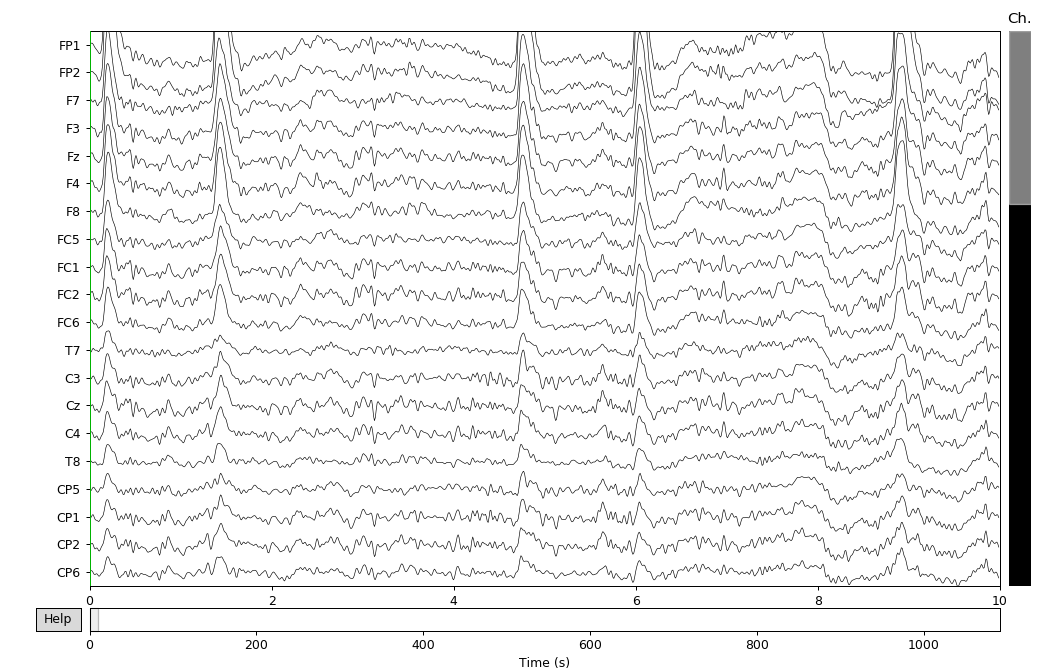

In [8]:
raw.plot();

Those big spikes are EOG (electrooculogram) artifacts. Electrical noise generated by eye movements. 
We can use a method called ICA to correct for those artifacts. Next session we will give you some more theoretical input of how it works, for now we will just create an ICA object
and use its `.fit` method on a filtered copy of the raw data:

In [9]:
ica = mne.preprocessing.ICA(n_components=20, random_state=0)

In [10]:
ica.fit(raw.copy().filter(8, 35))

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 165 samples (1.650 sec)

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 20 components
Fitting ICA took 1.6s.


<ICA  |  raw data decomposition, fit (fastica): 109098 samples, 20 components, channels used: "eeg">

<IPython.core.display.Javascript object>


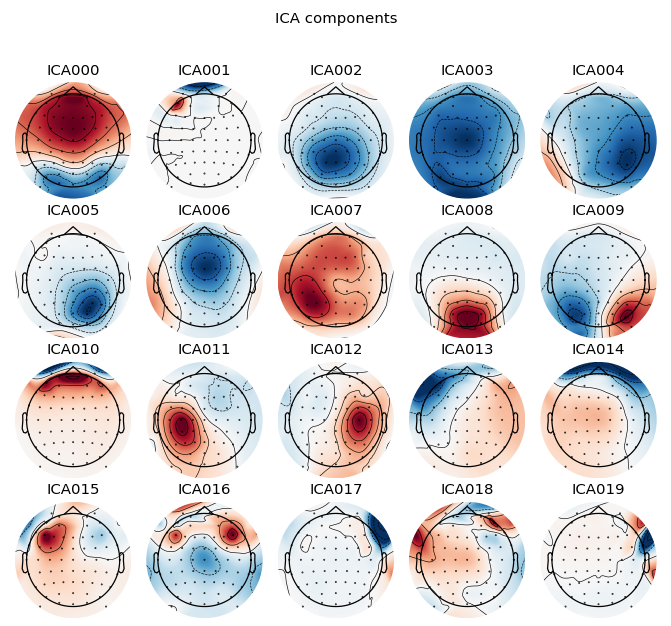

In [11]:
ica.plot_components(outlines="skirt");

We can use an algorithm to automatically find bad EOGs.

In [12]:
bad_idx, scores = ica.find_bads_eog(raw, 'SO2', threshold=2)
print(bad_idx)

Using channel SO2 as EOG channel
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1024 samples (10.240 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 

lets compare data before and after ica:

<IPython.core.display.Javascript object>


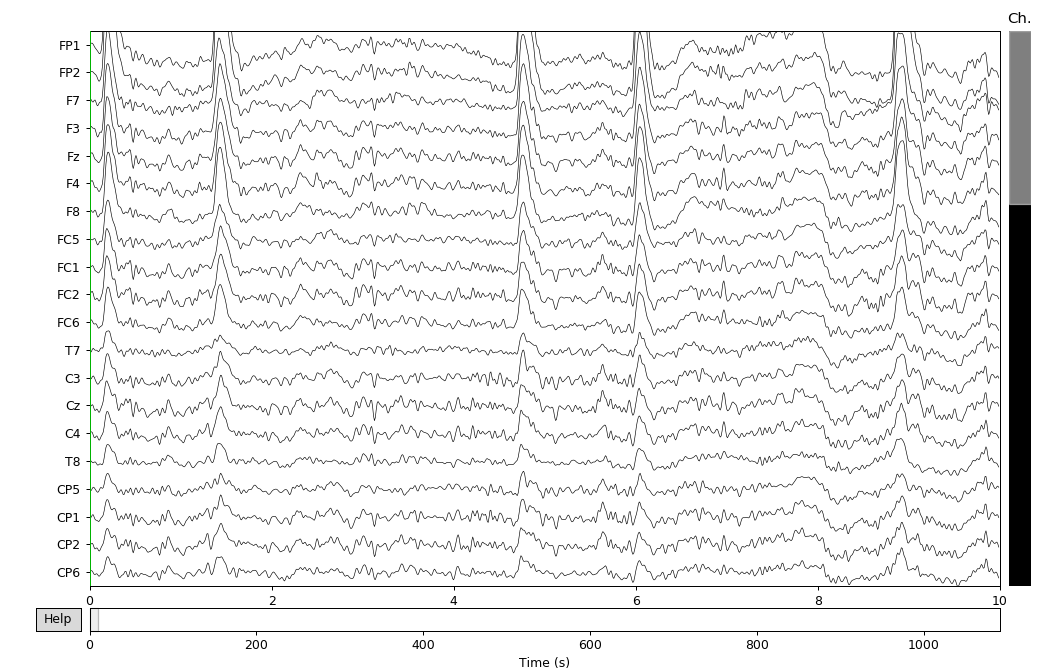

In [13]:
raw.plot();

Transforming to ICA space (20 components)
Zeroing out 2 ICA components


<IPython.core.display.Javascript object>


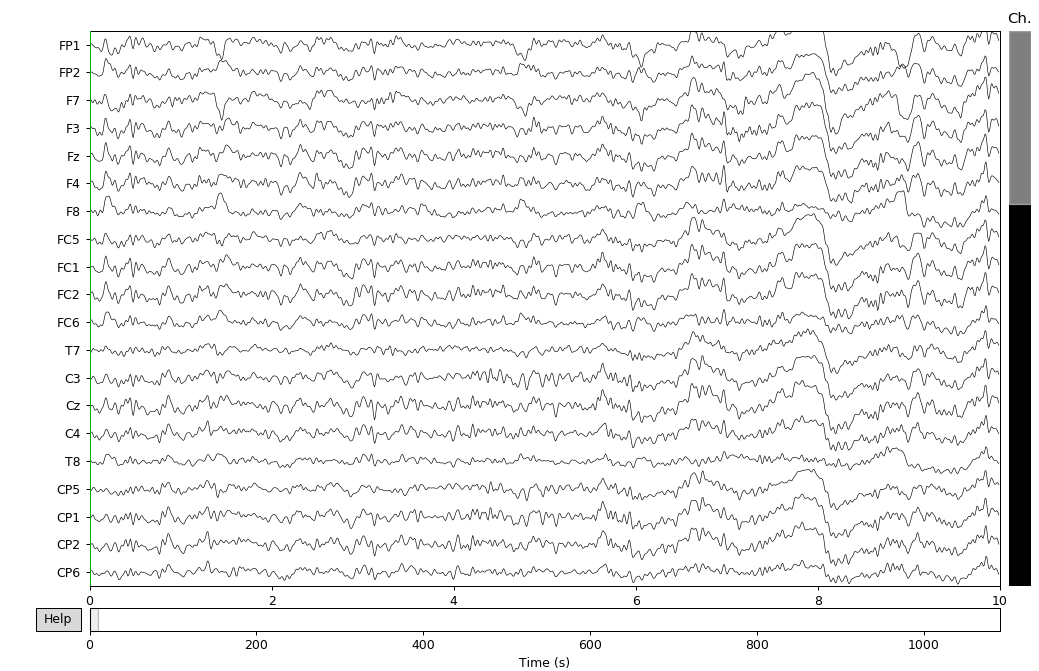

In [14]:
ica.apply(raw.copy(), exclude=bad_idx).plot();

## Epochs

For epoching the data, we need event markers. They can be stored in the `raw` object in the stimulus channel or created from annotations.

In [15]:
events = mne.find_events(raw)

903 events found
Event IDs: [100 200]


`events` is simply an array (time in samples, zero, trigger);

In [16]:
events

array([[  3241,      0,    200],
       [  3437,      0,    200],
       [  3643,      0,    200],
       ...,
       [111496,      0,    200],
       [111613,      0,    200],
       [111719,      0,    200]])

We can also visualize the events

<IPython.core.display.Javascript object>


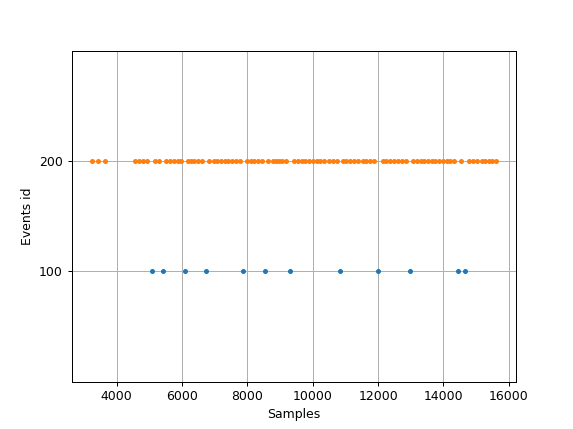

In [17]:
mne.viz.plot_events(events[:100]);

For creating an `mne.Epochs` object, we require, in addition to the `raw` object and the `events` array, a dictionary of the intended condition names and the corresponding trigger numbers.

In [18]:
event_ids = {"standard/stimulus": 200, "target/stimulus": 100}

epochs = mne.Epochs(raw, events, event_id=event_ids)

903 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


Aaaaaaand visualize

Loading data for 903 events and 71 original time points ...
0 bad epochs dropped
Loading data for 903 events and 71 original time points ...


<IPython.core.display.Javascript object>


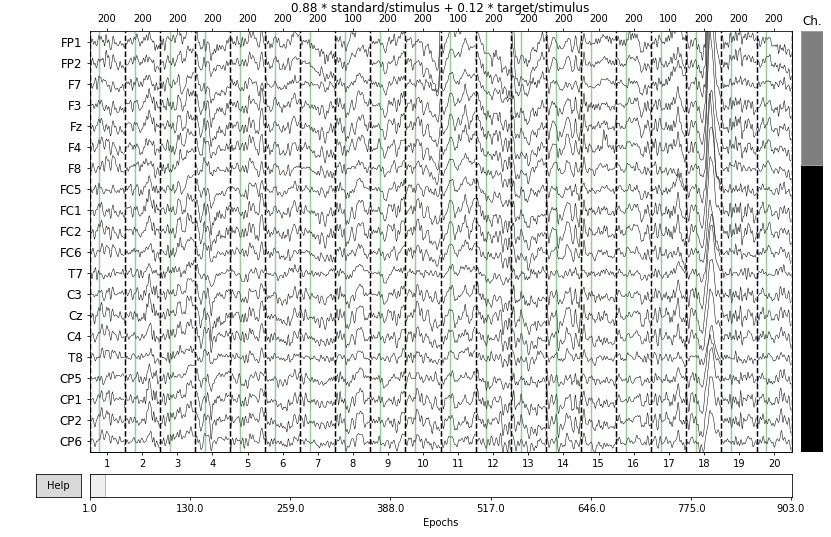

Loading data for 20 events and 71 original time points ...


In [19]:
epochs.plot();

We can also select specific events and only plot those. 

Loading data for 797 events and 71 original time points ...


<IPython.core.display.Javascript object>


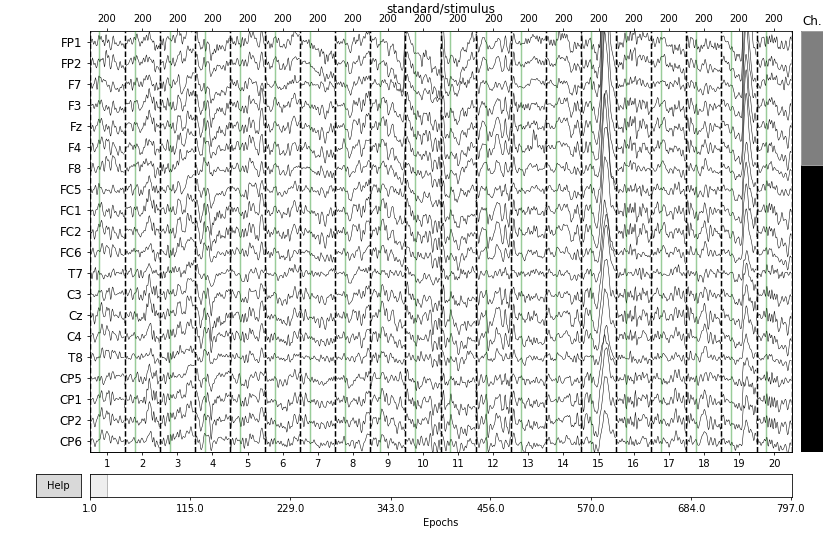

Loading data for 20 events and 71 original time points ...


In [20]:
epochs['standard'].plot();

Loading data for 106 events and 71 original time points ...


<IPython.core.display.Javascript object>


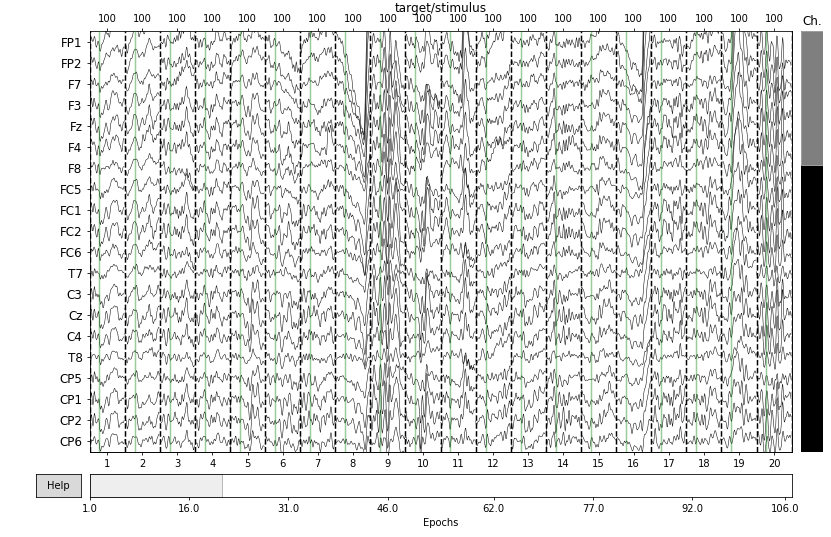

Loading data for 20 events and 71 original time points ...


In [21]:
epochs['target'].plot();

In [22]:
%matplotlib inline

Dropped 0 epochs
Channels marked as bad: []
Dropped 0 epochs
Channels marked as bad: []
Dropped 0 epochs
Channels marked as bad: []
Dropped 0 epochs
Channels marked as bad: []
Dropped 0 epochs
Channels marked as bad: []
Dropped 0 epochs
Channels marked as bad: []


Now we can correct for EOG components based on our epoched data

In [31]:
epochs = mne.Epochs(raw, events, event_id=event_ids, tmin=-.2, tmax=.5, preload=True)
epochs = ica.apply(epochs, exclude=bad_idx)

903 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 903 events and 71 original time points ...
0 bad epochs dropped
Transforming to ICA space (20 components)
Zeroing out 2 ICA components


Epochs objects have many methods, including baselining and time window length.

In [32]:
epochs.apply_baseline((None, 0))

Applying baseline correction (mode: mean)


<Epochs  |   903 events (all good), -0.2 - 0.5 sec, baseline [None, 0], ~31.4 MB, data loaded,
 'standard/stimulus': 797
 'target/stimulus': 106>

In [34]:
epochs.equalize_event_counts(event_ids)
epochs

Dropped 691 epochs


<Epochs  |   212 events (all good), -0.2 - 0.5 sec, baseline [None, 0], ~7.5 MB, data loaded,
 'standard/stimulus': 106
 'target/stimulus': 106>

We can also save our epoched data to disk, so that we don't have to redo all the preprocessing the next time.

In [35]:
epochs.save("oddball-epo.fif")  # remember, the data has been cleaned of bad ICs

<ipython-input-35-94f0ec168e5e>:1: DeprecationWarning: overwrite defaults to True in 0.18 but will change to False in 0.19, set it explicitly to avoid this warning
  epochs.save("oddball-epo.fif")  # remember, the data has been cleaned of bad ICs


## Evokeds

Evoked objects are averaged epoched data over trials.

In [38]:
target = epochs["target"].average()
standard = epochs["standard"].average()

There are a number of plotting functions for inspecting the evoked object.

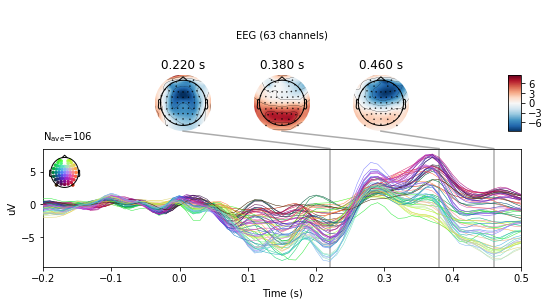

In [39]:
target.plot_joint();

For inspecting contrasts we can use joint plots:

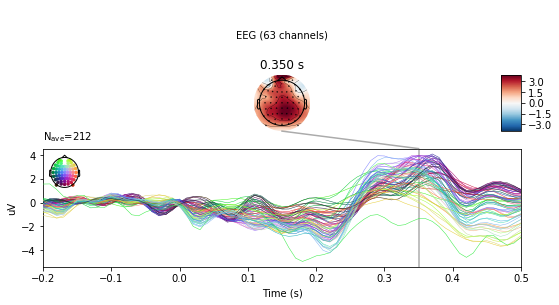

In [40]:
diff = mne.combine_evoked((target, -standard), weights='equal')
diff.plot_joint(times=.35);

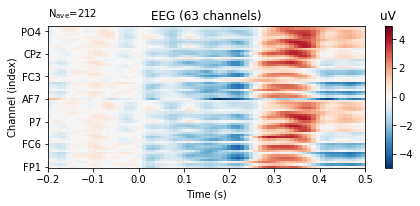

In [41]:
diff.plot_image();

To contrast multiple conditions, `mne.viz.plot_compare_evokeds` is available:

No picks, plotting the GFP ...


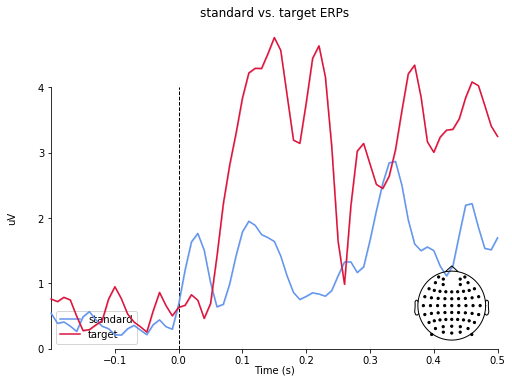

In [46]:
mne.viz.plot_compare_evokeds({"standard": standard,
                              "target": target}, 
                             title="standard vs. target ERPs",
                             show_sensors="lower right", truncate_yaxis="max_ticks");

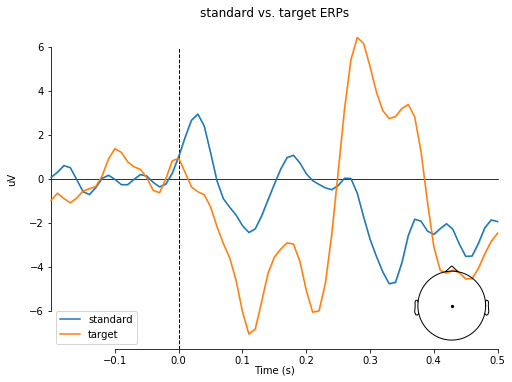

In [48]:
mne.viz.plot_compare_evokeds({"standard": standard,
                              "target": target}, 
                             picks=[13],
                             title="standard vs. target ERPs",
                             show_sensors="lower right", truncate_yaxis="max_ticks");